In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import math
import random


In [3]:
def generate_polynomial_coeff(a_min, a_max):
    """
    Generates a random square polynomial that has a critical point
    that has coordinates (x;y) where 0 < x < 1 and 0 < y < 1
    Returns coefficiants for the polynomial: ax^2 + bx + c where a is in range [a_min; a_max]
    a MUST be positive -> the polynomial ir upright
    """
    # define a range as [a_min;a_max]
    a = random.uniform(a_min, a_max)
    # b must be in range [-2a;0]
    b_min, b_max = -2*a, 0
    b = random.uniform(b_min, b_max)
    tmp = - (b**2)/(4*a) + (b**2)/(2*a)
    c_min = 1 + tmp
    c_max = tmp
    c = random.uniform(c_min, c_max)
    return (a, b, c)

In [4]:
def plot_polynomial(a, b, c, ax, color):
    x = np.linspace(0,1,64)
    y = a*(x**2) + b*x + c
    y[y>1]=1 # clip the function values to the correct range
    rgb = (random.random(), random.random(), random.random())
    ax.plot(x,y, color=rgb)
    

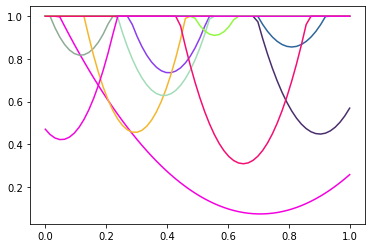

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(10):
    a,b,c = generate_polynomial_coeff(0, 20)
    plot_polynomial(a, b, c, ax, i)
    x_sol = -b/(2*a)
    y_sol = a*(x_sol**2) + b*x_sol + c
    if x_sol < 0 or x_sol > 1 or y_sol < 0 or y_sol > 1:
        print(f"Error P: {a}x^2 + {b}x + {c} -> critical point at: ({x_sol}; {y_sol})")

# show the plot
plt.show()


In [6]:
def generate_non_differentiable_mask(start, stop, steps, polynomials):
    x = np.linspace(start, stop, steps)
    y = np.ones_like(x)
    for i in range(polynomials):
        a,b,c = generate_polynomial_coeff(0, 20)
        poly_y = a*(x**2) + b*x + c
        poly_y[poly_y>1] = 1
        y = np.minimum(y, poly_y)
    return y

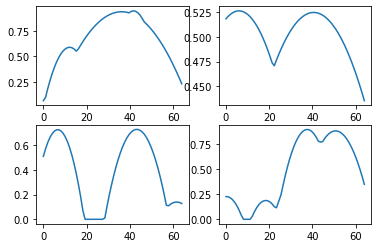

In [7]:
fig = plt.figure()
for i in range(4):
    ax = fig.add_subplot(2, 2, i+1)

    x = np.linspace(0,64,64)
    y = 1- generate_non_differentiable_mask(0, 1, 64, 5)
    ax.plot(x,y)

In [8]:
# brute-force correctness validation
for i in range(100000):
    a,b,c = generate_polynomial_coeff(0, 10000)
    x_sol = -b/(2*a)
    y_sol = a*(x_sol**2) + b*x_sol + c
    if x_sol < 0 or x_sol > 1 or y_sol < 0 or y_sol > 1:
        print(f"Incorrect P: {a}x^2 + {b}x + {c} -> critical point at: ({x_sol}; {y_sol})")
        b_in_range = b < 0 and b > (-2*a)
        c_in_range = 0 < (((b**2)/(4*a)) - ((b**2)/(2*a)) + c) and 1 > (((b**2)/(4*a)) - ((b**2)/(2*a)) + c)
        print(f"b in range: {b_in_range}, c in range: {c_in_range}")

In [9]:
import torch
# test application to spectrogram in batch form: (batch_size, channel_count, height, width)
spectrogram = torch.ones(2, 1, 3, 5)
multiplier = torch.ones_like(spectrogram)
# iterate over batches
spec_height = spectrogram.shape[-2]
spec_width = spectrogram.shape[-1]
for i, spectrogram_item in enumerate(spectrogram):
    (a, b, c) = generate_polynomial_coeff(0, 20)
#     (a, b, c) = (0, 1, 0)
    sampling_x = torch.linspace(0,1, spec_height)
    filter_samples_y = a*(torch.pow(sampling_x, 2)) + b*sampling_x + c
    filter_samples_y[filter_samples_y > 1] = 1
    spectrogram_item_multiplier = filter_samples_y.view((spec_height, 1)).repeat((1, spec_width)).view(1, spec_height, spec_width)
    multiplier[i] = spectrogram_item_multiplier
# inverse cut:
multiplier = 1 - multiplier
print("mock spectrogram:")
display(spectrogram)
print("Poly mask:")
display(multiplier)
spectrogram = spectrogram*multiplier
print("Masked spectrogram:")
display(spectrogram)

mock spectrogram:


tensor([[[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]],


        [[[1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1.]]]])

Poly mask:


tensor([[[[0.9385, 0.9385, 0.9385, 0.9385, 0.9385],
          [0.3154, 0.3154, 0.3154, 0.3154, 0.3154],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.6506, 0.6506, 0.6506, 0.6506, 0.6506],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])

Masked spectrogram:


tensor([[[[0.9385, 0.9385, 0.9385, 0.9385, 0.9385],
          [0.3154, 0.3154, 0.3154, 0.3154, 0.3154],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]],


        [[[0.6506, 0.6506, 0.6506, 0.6506, 0.6506],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]]])